In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import pandas as pd
from sklearn.metrics import average_precision_score
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
import numpy as np
import seaborn as sns

In [2]:
os.chdir("..")
test = pd.read_parquet("data/online/test_raw.parquet")
train = pd.read_parquet("data/online/train_oss.parquet")

In [3]:
df = pd.concat([train, test], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 886255 entries, 0 to 178153
Data columns (total 58 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   client_id                        886255 non-null  int64  
 1   card_id                          886255 non-null  int64  
 2   amount                           886255 non-null  float32
 3   merchant_id                      886255 non-null  int64  
 4   current_age                      886255 non-null  int64  
 5   retirement_age                   886255 non-null  int64  
 6   birth_year                       886255 non-null  int64  
 7   birth_month                      886255 non-null  int8   
 8   latitude                         886255 non-null  float64
 9   longitude                        886255 non-null  float64
 10  per_capita_income                886255 non-null  float32
 11  yearly_income                    886255 non-null  float32
 12  total_d

In [4]:
df.shape

(886255, 58)

In [5]:
# fraud 데이터가 아예 없는 구간 drop
df = df[~df["tx_year"].isin([2017, 2018])].copy()

In [6]:
df.shape

(719351, 58)

In [7]:
# amount log 컬럼 추가
df = df[df["amount"] >= 0].copy()
df["log_amount"] = np.log1p(df["amount"])
df.shape

(715565, 59)

In [8]:
# Num_cards_issued drop
df.drop("num_cards_issued", axis=1, inplace=True)
df.shape

(715565, 58)

In [9]:
# hour
df["hour_sin"] = np.sin(2*np.pi*df["tx_hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["tx_hour"]/24)

In [10]:
# month
df["month_sin"] = np.sin(2 * np.pi * df["tx_month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["tx_month"] / 12)

In [11]:
# day
df.drop("tx_day", axis=1, inplace=True) 

In [12]:
# err
df.drop(columns=["err_bad_pin", "err_bad_zipcode", "err_technical_glitch"], inplace=True)

In [13]:
# months_to_expire_calc
tx_total_month = df["tx_year"] * 12 + df["tx_month"]
expire_total_month = df["expires_year"] * 12 + df["expires_month"]
df["months_to_expire_calc"] = expire_total_month - tx_total_month

In [14]:
# mccg_Medical
df.drop("mccg_Medical", axis=1, inplace=True)

In [15]:
df.shape

(715565, 58)

In [16]:
df.drop("birth_year", axis=1, inplace=True)

In [17]:
df.drop("merchant_id", axis=1, inplace=True)

In [18]:
df.drop("birth_month", axis=1, inplace=True)

In [19]:
df.drop("retirement_age", axis=1, inplace=True)

In [20]:
df.drop("is_online", axis=1, inplace=True)

In [21]:
df.drop(columns=["acct_open_year", "acct_open_month", "expires_year", "expires_month", "months_to_expire_calc"], inplace=True)

In [22]:
df.drop("amount", axis=1, inplace=True)

In [23]:
df.drop(columns=["has_error", "distance_imputed"], axis=1, inplace=True)

In [25]:
df.drop(columns=["latitude", "longitude"], inplace=True)

In [28]:
df.columns

Index(['client_id', 'card_id', 'current_age', 'per_capita_income',
       'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards',
       'has_chip', 'credit_limit', 'year_pin_last_changed',
       'err_bad_card_number', 'err_bad_expiration', 'err_bad_cvv',
       'err_insufficient_balance', 'months_to_expire', 'tx_year', 'tx_month',
       'tx_hour', 'is_weekend', 'is_credit', 'is_prepaid', 'male',
       'mccg_Food_Daily', 'mccg_Transport_Travel', 'mccg_Digital_Online',
       'mccg_Financial', 'mccg_Retail', 'mccg_Entertainment',
       'mccg_Automotive_Home', 'mccg_Utilities_Government',
       'mccg_Professional_Services', 'mccg_Industrial_/_Manufacturing',
       'cb_Visa', 'cb_Mastercard', 'cb_Amex', 'cb_Discover', 'fraud',
       'log_amount', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos'],
      dtype='object')

In [ ]:
df.drop(columns=["tx_year", "tx_month", "tx_hour"], inplace=True)

,tx_year,tx_month,tx_hour
0,2010,1,0
1,2010,1,1
2,2010,1,1
3,2010,1,1
4,2010,1,1
5,2010,1,1
6,2010,1,2
7,2010,1,2
8,2010,1,2
9,2010,1,3


In [30]:
df.to_parquet("data/dataset")

In [31]:
df["cvv_high_amount"] = df["err_bad_cvv"] * df["log_amount"]

df["amount_hour_sin"] = df["log_amount"] * df["hour_sin"]
df["amount_hour_cos"] = df["log_amount"] * df["hour_cos"]

df["cvv_hour_sin"] = df["err_bad_cvv"] * df["hour_sin"]
df["cvv_hour_cos"] = df["err_bad_cvv"] * df["hour_cos"]

df["prepaid_high_amount"] = df["is_prepaid"] * df["log_amount"]

df["ind_high_amount"] = df["mccg_Industrial_/_Manufacturing"] * df["log_amount"]

df["ind_prepaid"] = (
    df["mccg_Industrial_/_Manufacturing"] * df["is_prepaid"]
)


In [32]:
def plot_interaction_feature_safe(df, col, kde_min_unique=30, sample_kde=200000):
    df2 = df[[col, "fraud"]].dropna().copy()

    df_nf = df2[df2["fraud"] == 0][col]
    df_f  = df2[df2["fraud"] == 1][col]


    # 1) 분포 비교: KDE 가능하면 KDE, 아니면 histogram

    nunique = df2[col].nunique(dropna=True)

    fig, ax = plt.subplots(1, 1, figsize=(10, 4))

    if nunique >= kde_min_unique and df2[col].std() > 0:
        # KDE는 샘플링해서 속도/안정성 확보
        s_nf = df_nf.sample(min(sample_kde, len(df_nf)), random_state=42) if len(df_nf) > sample_kde else df_nf
        s_f  = df_f.sample(min(sample_kde, len(df_f)), random_state=42)  if len(df_f)  > sample_kde else df_f

        # KDE 시도 (터지면 histogram으로 fallback)
        try:
            s_nf.plot.kde(ax=ax, label="Non-Fraud")
            s_f.plot.kde(ax=ax, label="Fraud")
            ax.set_title(f"{col} KDE by Fraud (sampled)")
            ax.set_xlabel(col)
            ax.legend()
        except Exception as e:
            ax.hist(df_nf, bins=50, alpha=0.6, label="Non-Fraud")
            ax.hist(df_f,  bins=50, alpha=0.6, label="Fraud")
            ax.set_yscale("log")
            ax.set_title(f"{col} Histogram by Fraud (KDE failed: {type(e).__name__})")
            ax.set_xlabel(col)
            ax.legend()
    else:
        # 희소/이산형이면 histogram이 더 적합
        ax.hist(df_nf, bins=50, alpha=0.6, label="Non-Fraud")
        ax.hist(df_f,  bins=50, alpha=0.6, label="Fraud")
        ax.set_yscale("log")
        ax.set_title(f"{col} Histogram by Fraud (sparse/discrete; KDE skipped)")
        ax.set_xlabel(col)
        ax.legend()

    plt.tight_layout()
    plt.show()

    # 2) Decile Fraud Rate

    try:
        bins = pd.qcut(df2[col], 10, duplicates="drop")
        fraud_rate = df2.groupby(bins)["fraud"].mean()

        plt.figure(figsize=(8, 4))
        fraud_rate.plot(marker="o")
        plt.ylabel("Fraud Rate")
        plt.xlabel(f"{col} (deciles)")
        plt.title(f"{col} Fraud Rate by Decile")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"[Decile plot skipped] {col}: {e}")

    # 3) 0 vs >0 비교: 희소 interaction에 특히 유용

    if (df2[col] == 0).mean() > 0.5:
        rate0 = df2.loc[df2[col] == 0, "fraud"].mean()
        rate1 = df2.loc[df2[col] != 0, "fraud"].mean()
        print(f"[0 vs non-zero] {col}: fraud_rate(0)={rate0:.6f}, fraud_rate(nonzero)={rate1:.6f}, nonzero_rate={(df2[col]!=0).mean():.4f}")


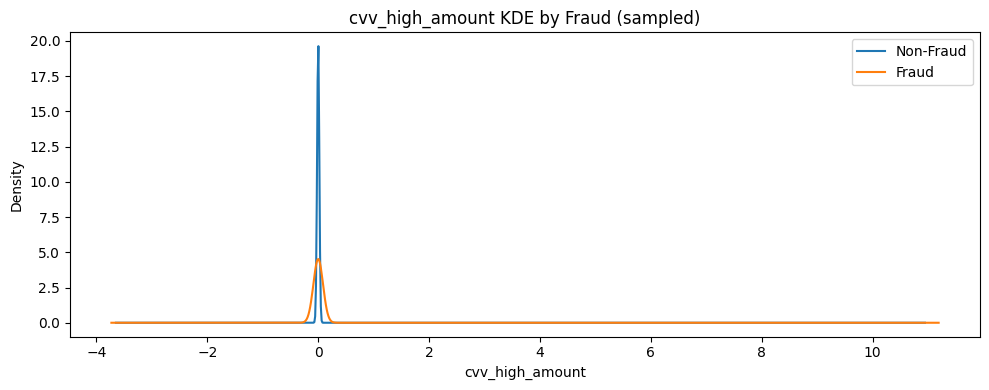

/tmp/ipykernel_4135145/2242752698.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = df2.groupby(bins)["fraud"].mean()


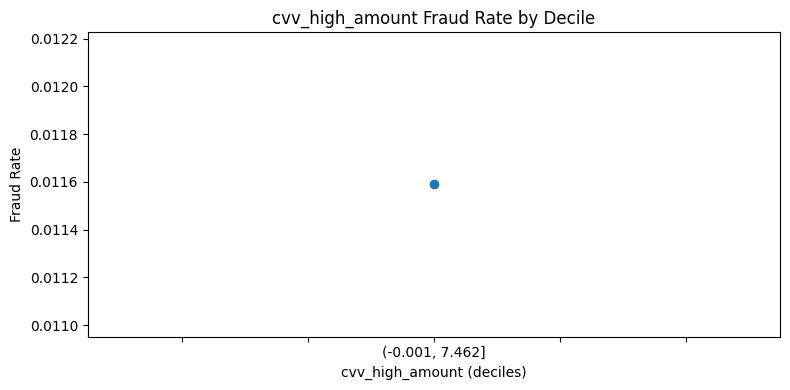

[0 vs non-zero] cvv_high_amount: fraud_rate(0)=0.011453, fraud_rate(nonzero)=0.045002, nonzero_rate=0.0041


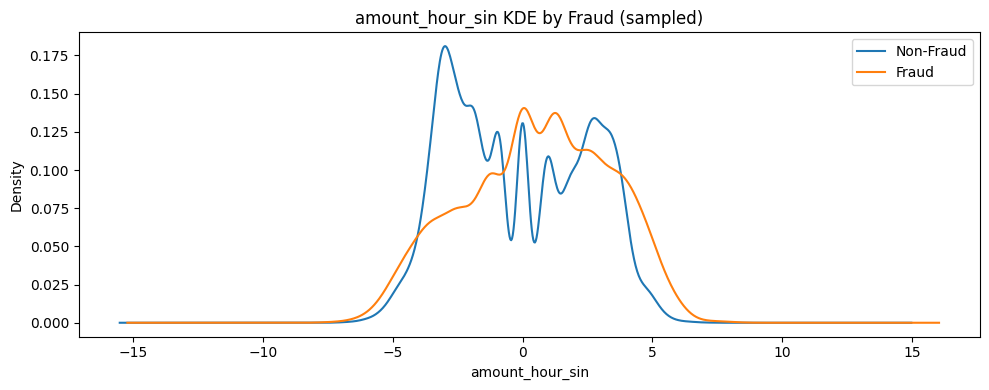

/tmp/ipykernel_4135145/2242752698.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = df2.groupby(bins)["fraud"].mean()


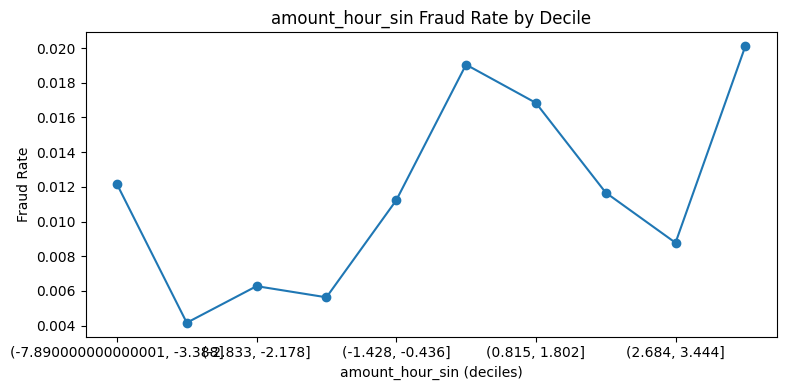

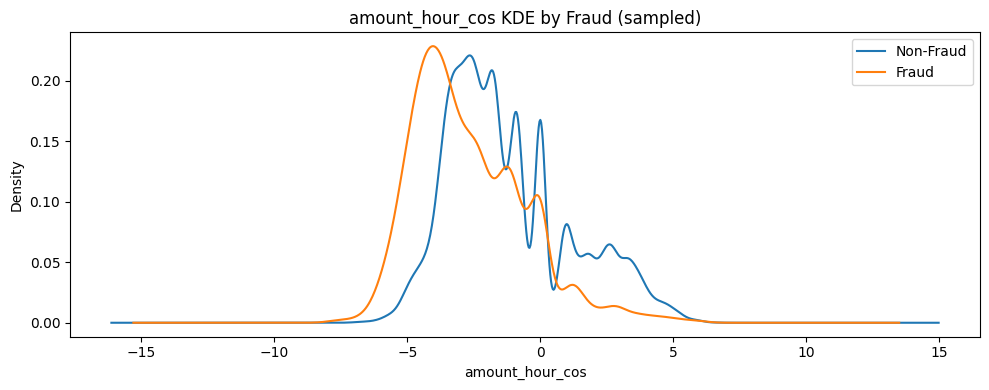

/tmp/ipykernel_4135145/2242752698.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = df2.groupby(bins)["fraud"].mean()


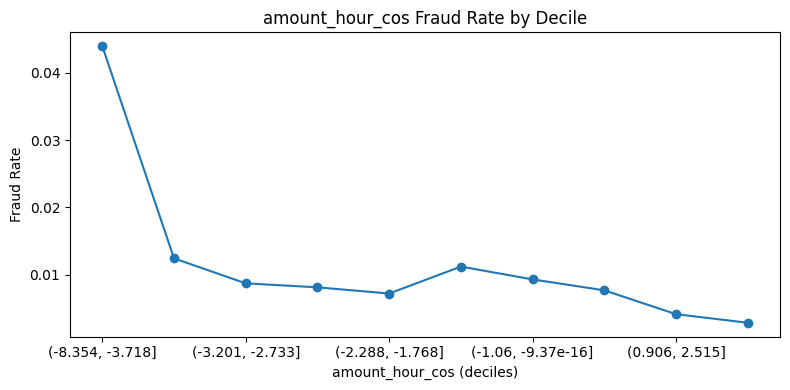

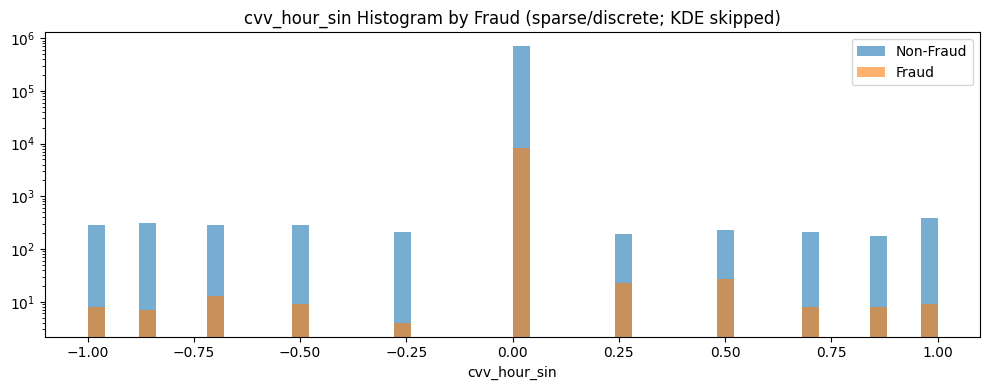

/tmp/ipykernel_4135145/2242752698.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = df2.groupby(bins)["fraud"].mean()


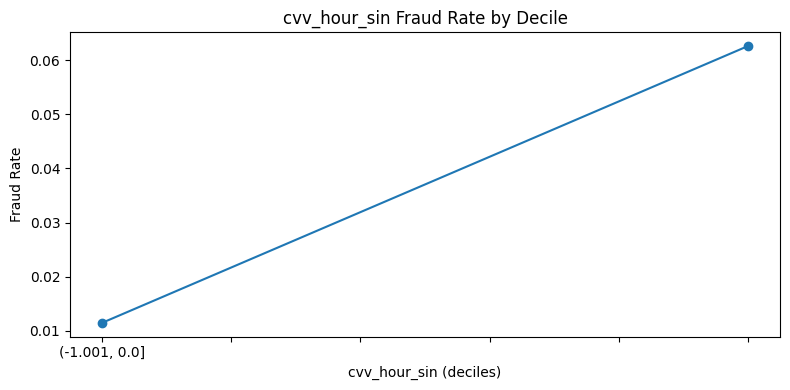

[0 vs non-zero] cvv_hour_sin: fraud_rate(0)=0.011452, fraud_rate(nonzero)=0.045724, nonzero_rate=0.0040


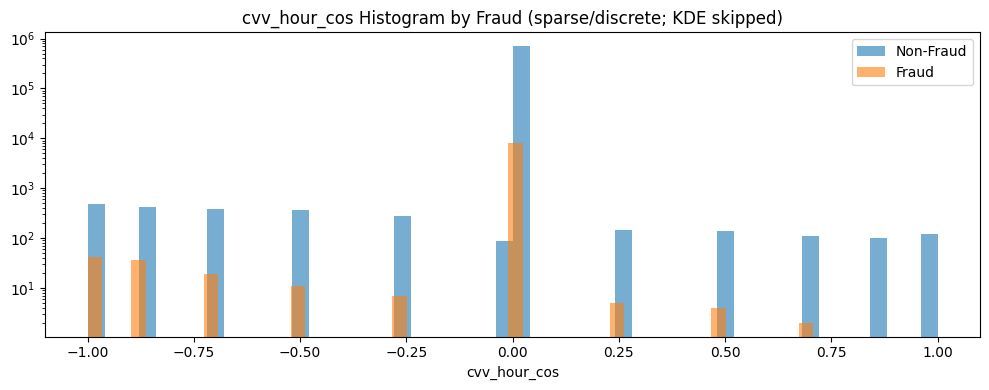

/tmp/ipykernel_4135145/2242752698.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = df2.groupby(bins)["fraud"].mean()


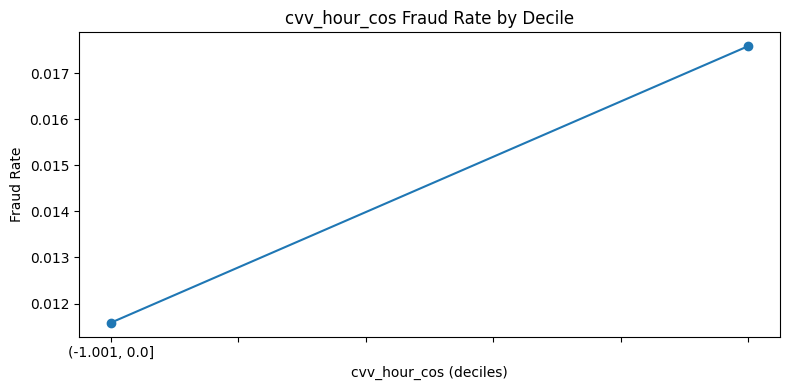

[0 vs non-zero] cvv_hour_cos: fraud_rate(0)=0.011453, fraud_rate(nonzero)=0.045002, nonzero_rate=0.0041


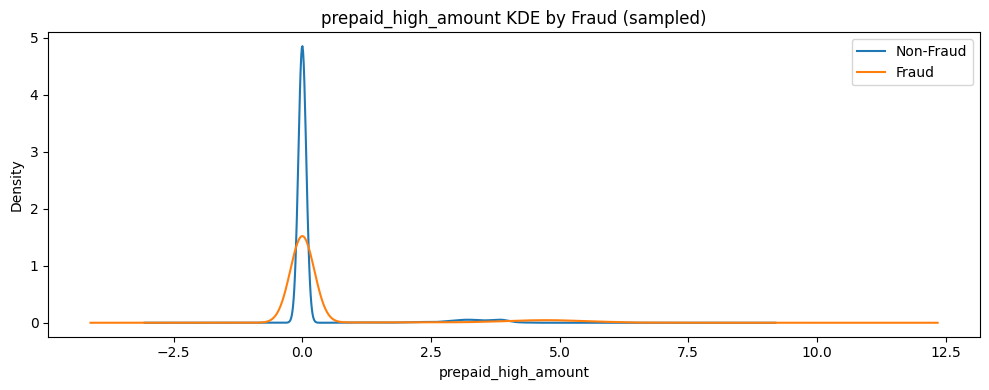

/tmp/ipykernel_4135145/2242752698.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = df2.groupby(bins)["fraud"].mean()


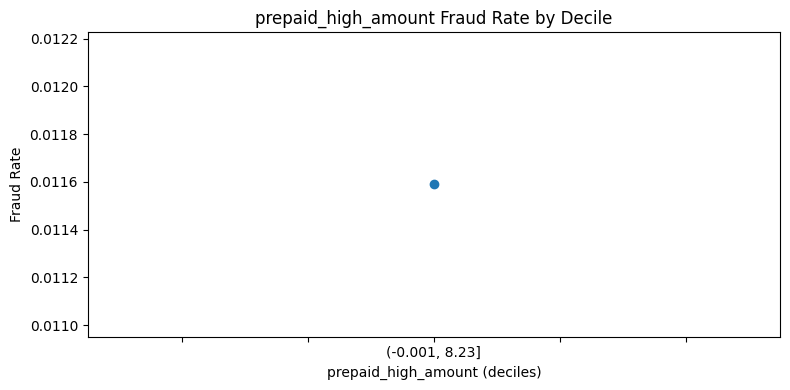

[0 vs non-zero] prepaid_high_amount: fraud_rate(0)=0.011141, fraud_rate(nonzero)=0.017017, nonzero_rate=0.0763


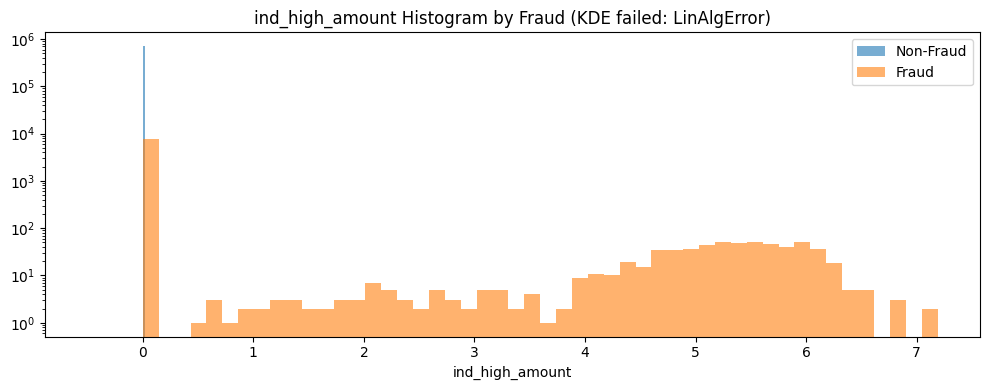

/tmp/ipykernel_4135145/2242752698.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = df2.groupby(bins)["fraud"].mean()


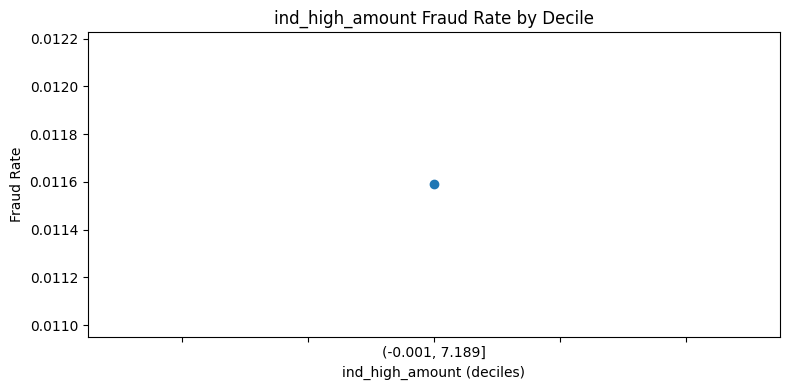

[0 vs non-zero] ind_high_amount: fraud_rate(0)=0.010696, fraud_rate(nonzero)=1.000000, nonzero_rate=0.0009


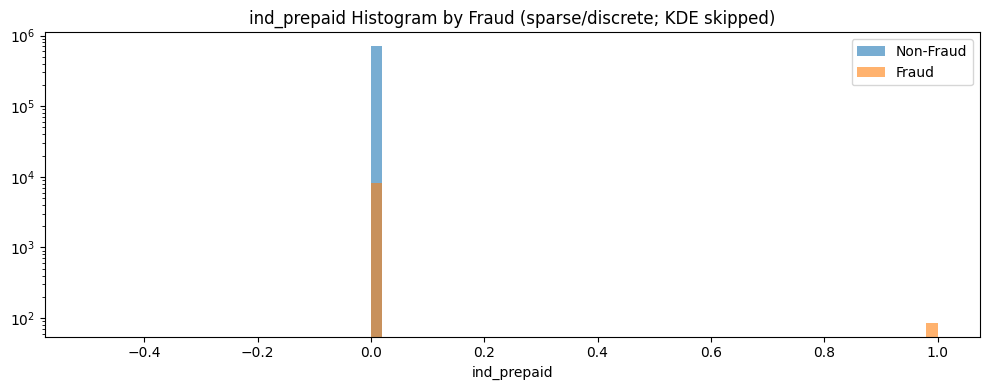

/tmp/ipykernel_4135145/2242752698.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = df2.groupby(bins)["fraud"].mean()


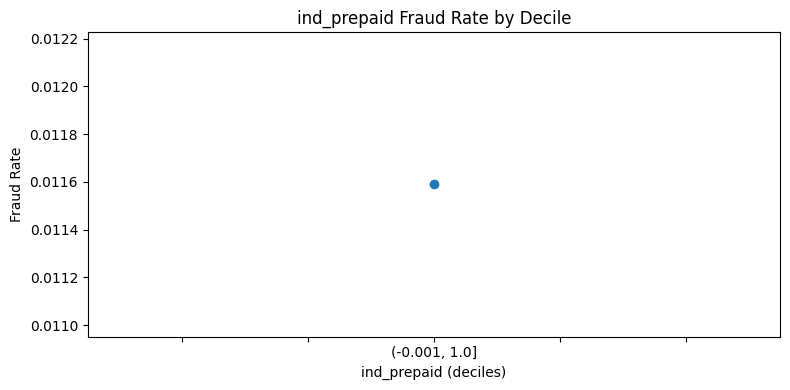

[0 vs non-zero] ind_prepaid: fraud_rate(0)=0.011471, fraud_rate(nonzero)=1.000000, nonzero_rate=0.0001


In [33]:
for c in [
    "cvv_high_amount",
    "amount_hour_sin", "amount_hour_cos",
    "cvv_hour_sin", "cvv_hour_cos",
    "prepaid_high_amount",
    "ind_high_amount",
    "ind_prepaid",
]:
    plot_interaction_feature_safe(df, c)


In [34]:

def evaluate_numeric_feature_safe(df, feature):
    s = df[feature]
    y = df["fraud"]

    m = s.notna() & y.notna()
    s = s[m]
    y = y[m]

    x_nf = s[y == 0]
    x_f  = s[y == 1]

    ks_stat, ks_p = ks_2samp(x_nf, x_f)
    mw_stat, mw_p = mannwhitneyu(x_nf, x_f, alternative="two-sided")

    def cohens_d(x, z):
        nx, nz = len(x), len(z)
        pooled_std = np.sqrt(((nx-1)*x.std()**2 + (nz-1)*z.std()**2) / (nx+nz-2))
        return (x.mean() - z.mean()) / pooled_std

    d = cohens_d(x_f, x_nf)

    pr_auc = average_precision_score(y, s)

    # logit (실패하면 NaN 처리)
    odds_ratio = np.nan
    logit_p = np.nan
    try:
        X = sm.add_constant(s.to_frame())
        model = sm.Logit(y, X).fit(disp=0)
        odds_ratio = float(np.exp(model.params[feature]))
        logit_p = float(model.pvalues[feature])
    except Exception:
        pass

    return pd.Series({
        "KS_p": ks_p,
        "MW_p": mw_p,
        "Cohen_d": d,
        "Odds_Ratio": odds_ratio,
        "Logit_p": logit_p,
        "PR_AUC": pr_auc,
        "n": len(s),
        "pos_rate": float(y.mean())
    })


In [35]:
for c in [
    "cvv_high_amount",
    "amount_hour_sin", "amount_hour_cos",
    "cvv_hour_sin", "cvv_hour_cos",
    "prepaid_high_amount",
    "ind_high_amount",
    "ind_prepaid",
]:
    print(f"{c}")
    print(evaluate_numeric_feature_safe(df, c))

cvv_high_amount
KS_p          1.971115e-01
MW_p          4.746463e-64
Cohen_d       1.983516e-01
Odds_Ratio    1.435678e+00
Logit_p       3.124711e-60
PR_AUC        1.293632e-02
n             7.155650e+05
pos_rate      1.158944e-02
dtype: float64
amount_hour_sin
KS_p          2.642943e-198
MW_p          2.696674e-132
Cohen_d        2.725802e-01
Odds_Ratio     1.107807e+00
Logit_p       2.004236e-132
PR_AUC         1.954481e-02
n              7.155650e+05
pos_rate       1.158944e-02
dtype: float64
amount_hour_cos
KS_p               0.000000
MW_p               0.000000
Cohen_d           -0.635445
Odds_Ratio         0.686365
Logit_p            0.000000
PR_AUC             0.007666
n             715565.000000
pos_rate           0.011589
dtype: float64
cvv_hour_sin
KS_p          5.250117e-01
MW_p          1.562039e-17
Cohen_d       3.572844e-02
Odds_Ratio    2.102342e+00
Logit_p       8.866263e-04
PR_AUC        1.194899e-02
n             7.155650e+05
pos_rate      1.158944e-02
dtype: float64

/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KS_p          1.043416e-43
MW_p          0.000000e+00
Cohen_d       2.623451e+00
Odds_Ratio    4.299357e+61
Logit_p       9.309816e-01
PR_AUC        8.858368e-02
n             7.155650e+05
pos_rate      1.158944e-02
dtype: float64
ind_prepaid
KS_p               0.339006
MW_p               0.000000
Cohen_d            0.950879
Odds_Ratio              NaN
Logit_p                 NaN
PR_AUC             0.021839
n             715565.000000
pos_rate           0.011589
dtype: float64


In [36]:
df.drop(columns=["amount_hour_cos", "ind_prepaid", "cvv_hour_sin"], inplace=True)

In [37]:
df.to_parquet("data/dataset2")

In [38]:
df.shape

(715565, 48)

In [39]:
df.columns

Index(['client_id', 'card_id', 'current_age', 'per_capita_income',
       'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards',
       'has_chip', 'credit_limit', 'year_pin_last_changed',
       'err_bad_card_number', 'err_bad_expiration', 'err_bad_cvv',
       'err_insufficient_balance', 'months_to_expire', 'tx_year', 'tx_month',
       'tx_hour', 'is_weekend', 'is_credit', 'is_prepaid', 'male',
       'mccg_Food_Daily', 'mccg_Transport_Travel', 'mccg_Digital_Online',
       'mccg_Financial', 'mccg_Retail', 'mccg_Entertainment',
       'mccg_Automotive_Home', 'mccg_Utilities_Government',
       'mccg_Professional_Services', 'mccg_Industrial_/_Manufacturing',
       'cb_Visa', 'cb_Mastercard', 'cb_Amex', 'cb_Discover', 'fraud',
       'log_amount', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
       'cvv_high_amount', 'amount_hour_sin', 'cvv_hour_cos',
       'prepaid_high_amount', 'ind_high_amount'],
      dtype='object')